# Data Mining homework 2

### by Skander Chouchene

The purpose of the second homework is to apply clustering methods we saw in class on the reward/risk space for the 84 stocks in the provided dataset, and to draw observations and interpretations.

In [1]:
# import necessary libraries
import pandas as pd # pandas
import seaborn as sns # seaborn package to generate nice plots
import matplotlib.pyplot as plt # matplotlib
import numpy as np # numpy
import statsmodels.stats.api as sms
import scipy

In [196]:
# read data
data=pd.read_csv('tn_stock_data_2018.csv')
# convert date from string to datetime type
data.date=pd.to_datetime(data.date,format='%d/%m/%y')

In [197]:
data.drop("I",axis=1,inplace=True)

In [198]:
# show top observations from the data
data.head()

,date,C_GR_RLC,company_code,company,ref_price,yesterday_price,open,last,close,low,high,qty_traded,num_trades,value
0,2018-01-02,11,725001,ADWYA,5.35,5.35,5.25,5.39,5.39,5.25,5.39,2926,7,15635.50
1,2018-01-02,11,340005,AMEN BANK,24.35,24.35,24.38,24.00,24.00,24.00,24.38,1519,12,36918.00
2,2018-01-02,11,730001,ARTES,6.27,6.20,6.27,6.10,6.10,6.09,6.27,35875,67,219020.05
3,2018-01-02,11,714001,ASSAD,9.00,9.00,0.00,0.00,9.00,0.00,0.00,0,0,NaN
4,2018-01-02,11,360035,ATB,4.22,4.22,4.15,4.18,4.18,4.15,4.18,3705,7,15465.90


In [199]:
# calculate daily return for every company
data['currReturn']=data.groupby(['company'])['close'].pct_change()

In [200]:
# make a pivot to create a data matrix where columns are companies and rows are days; the values in the data matrix are for the returns
ret_data=data.pivot(index='date',columns='company',values='currReturn').dropna()

In [201]:
# calculate reward (i.e. average daily returns in bps) and risk (i.e. daily rets sdev)
ret_data=ret_data.drop(['AMI DA 1/4 110817'],1)
cluster_data=pd.concat([10000*ret_data.replace([np.inf, -np.inf], np.nan).mean(),(10000*ret_data.replace([np.inf, -np.inf], np.nan)).std()],1)
cluster_data.columns = ['reward','risk']

In [202]:
cluster_data.head()

,reward,risk
company,,
ADWYA,-4.865461,114.768932
AETECH,-11.500226,225.469155
AIR LIQUDE TSIE,-0.893395,139.062298
ALKIMIA,-1.018924,147.350192
AMEN BANK,6.447033,102.154216


In [203]:
# run a describe
cluster_data.describe()

,reward,risk
count,83.000000,83.000000
mean,1.274717,173.936331
std,15.068218,75.638934
min,-34.026761,58.033428
25%,-6.163269,134.426540
50%,-0.319128,163.192851
75%,6.441663,198.397954
max,77.934554,651.028387


#### Question : Using the reward/risk data and the clustering methods we have seen in class, generate a scatter plot with all the observations and then generate groups of stocks that have similar risk reward behaviour with different parameters and clustering methods. Are there any interpretations you can make?


## I/ KMeans Clustering:

#### The KMeans algorithm works by putting the points into k clusters in a way that minimizes a certain distance metric between them.

Text(0, 0.5, 'risk')

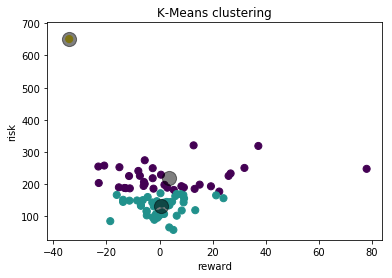

In [204]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
X=cluster_data.to_numpy()
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

plt.title("K-Means clustering")
plt.xlabel("reward")
plt.ylabel("risk")

### Interpretation:
#### There is one point that is making the plot harder to read. This point has a risk of 651 and belongs to POULINA. And from the previous notebooks in this course and the Data Analysis course we know that this is an outlier. It's more convenient to remove it. We will also remove the reward outlier ICF with over 70 reward.

In [205]:
print(cluster_data[cluster_data["risk"]>650])
print(cluster_data[cluster_data["reward"]>70])

                       reward        risk
company                                  
POULINA GP HOLDING -34.026761  651.028387
            reward        risk
company                       
ICF      77.934554  247.797324


Text(0, 0.5, 'risk')

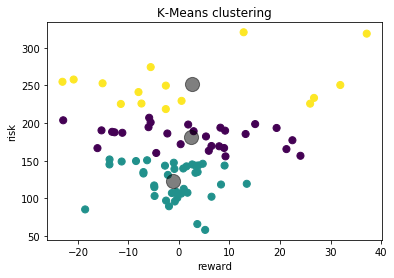

In [206]:
cluster_data=cluster_data[cluster_data["risk"]<600]
cluster_data=cluster_data[cluster_data["reward"]<70]
X=cluster_data.to_numpy()

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

plt.title("K-Means clustering")
plt.xlabel("reward")
plt.ylabel("risk")

### Interpretation
#### The KMeans clusters the data in 3 clusters that seem to differentiate between each other in risk level. The cluster centroids seems to not vary much according to the 'reward axis', which means the real differenciator here is the 'risk' factor. This also comes from the small size of our dataset which I will elaborate on more in the conclusion.
#### Of course this interpretation can be false if the optimal number of clusters is not 3, which is why we will test that in the next cell.

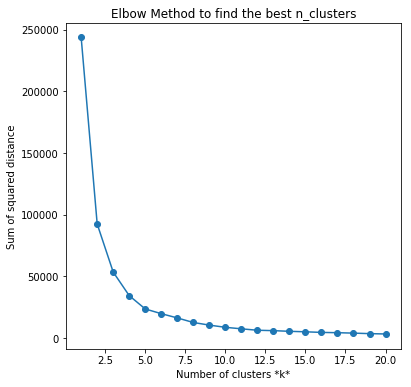

In [207]:
sse = []
list_k = list(range(1, 21))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(cluster_data)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.title("Elbow Method to find the best n_clusters")
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

### Interpretation
#### We used the elbow method that determines the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use.
#### The Elbow point seems to be around 3 or 4, which is the optimal number of clusters. And the interpretation above holds up.

## II/ Spectral Clustering:

#### In spectral clustering, data points are considered as nodes of a connected graph and clusters are found by partitioning this graph, based on its spectral decomposition, into subgraphs. 

Text(0, 0.5, 'risk')

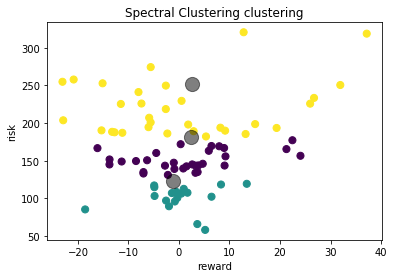

In [208]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=3, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);


plt.title("Spectral Clustering clustering")
plt.xlabel("reward")
plt.ylabel("risk")

#### The Spectral Clustering algorithm seems to give the upper cluster more points.

## III/ Gaussian Mixture Clustering:

#### An advantage of the GMM algorithm is that it accounts for variance. This can make it detect patterns in a better way than KMeans.

Text(0, 0.5, 'risk')

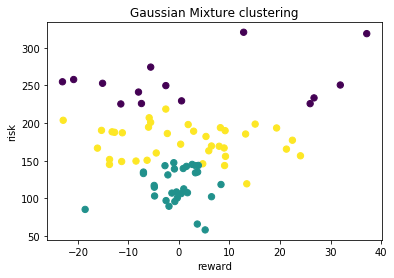

In [209]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

plt.title("Gaussian Mixture clustering")
plt.xlabel("reward")
plt.ylabel("risk")

Text(0.5, 1.0, 'Bayesian information criterion (BIC) with respect to n_components')

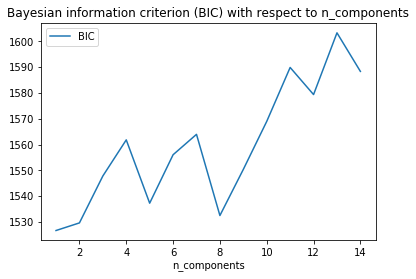

In [210]:
n_components = np.arange(1, 15)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(cluster_data)
          for n in n_components]

plt.plot(n_components, [m.bic(cluster_data) for m in models], label='BIC')
plt.legend(loc='best')
plt.xlabel('n_components');

plt.title("Bayesian information criterion (BIC) with respect to n_components")

### Interpretation
#### The BIC (Bayesian information criterion) indicates that the best pick for n_components is 8.

### GMM with 6 components

Text(0, 0.5, 'risk')

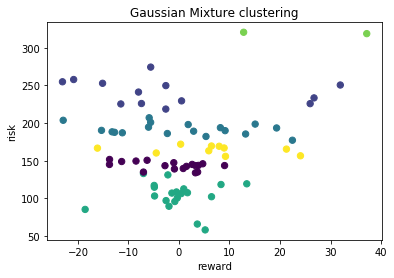

In [211]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components=6).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

plt.title("Gaussian Mixture clustering")
plt.xlabel("reward")
plt.ylabel("risk")

### General conclusion:
#### Throughout all these clustering algorithms, the output seems to differenciate mainly by risk. The clustering for this dataset outputs clusters that can be considered levels of risk (In case of 3 clusters: Low risk, Moderate risk, High risk).
#### One possible reason for this simplistic output is that the number of companies in the BVMT is low (84). This cannot offer much diversity when it comes to the couple of (risk, reward). While it is certain to find companies with "high risk high reward" or "low risk low reward", however the number of companies is not high enough to create a cluster of itself and still maintain a good disposition of clusters.
#### There is one glaring outlier case which is POULINA Group, a group with "high risk low reward" which is very baffling especially for a gargantuan group. Yet the size and nature of POULINA might be the cause.